# Cement Plant Type Identification 

## Overview

Cement production cycle comprises three main stages:

- Preparation of raw materials where limestone and silica-bearing minerals (clay, shale) are quarried and ground into a fine powder called raw meal
- Raw meal is heated in a kiln at temperatures as high as 1450 °C - chemical bonds of raw materials break down to produce clinker (calcined limestone): https://en.wikipedia.org/wiki/Cement_clinker - significant amounts of carbon dioxide (CO2) are released during this process
- Clinker is crushed and grounded into a fine powder in a cement mill and mixed with calcium sulphates (gypsum or anhydrite) to create cement: https://en.wikipedia.org/wiki/Cement_mill

Cement factories are classified into three categories with reference to their onsite facilities:

- Clinker Plant - focused on clinker production only (one or more kilns onsite)
- Integrated Cement Plant - undertake clinkerization and grinding manufacturing processes (one or more kilns onsite)
- Grinding (Cement Mill) - facilities specialised in the grinding process only

## Objective

This notebook reviews feasibility of building a computer vision model to automate reliable identification of factory type from high resolution optical satellite imagery. To establish a baseline, preliminary analysis focussed on training a standard convolutional neural network (CNN) to classify image chips coincident with cement factory locations into integrated and grinding plant categories. 

## Datasets

High resolution optical satellite imagery coincident with cement plant sites across the world was preprocessed into a collection of 256x256 pixel RGB JPEG files grouped into integrated and grinding sub-directories. To compute and evaluate model, categorised image chips were divided into training and test subsets according to 80-20 split - https://towardsdatascience.com/finally-why-we-use-an-80-20-split-for-training-and-test-data-plus-an-alternative-method-oh-yes-edc77e96295d. Subsequent cells manage download of this dataset from GCS bucket to local file system using Google Cloud SDK Python API.

In [1]:
import os

# authentication key
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='C:/Users/Chris.Williams/.gcs/arkham-255409-c59a52d8653f.json'

In [2]:
from google.cloud import storage
from io import BytesIO

# download pretrained model from google cloud
client = storage.Client()
bucket = client.get_bucket('eo-ald-update')

# construct remote path
repo = 'ald'
filenames = [ 'models\\vgg16-256-128.zip', 'data\\chips.zip' ]

# check files exist
for f in filenames:

    pathname = os.path.join( os.getcwd(), f )
    if not os.path.exists( pathname ):
                
        # make sub-directory if required
        if not os.path.exists ( os.path.dirname( pathname ) ):
            os.makedirs( os.path.dirname( pathname ) )

        # download blob
        remote_url = '{}/cement/plant-type/{}'.format( repo, f )

        blob = storage.blob.Blob( remote_url, bucket)
        with open( pathname, 'w+b' ) as z:
            blob.download_to_file( z )


In [3]:
from zipfile import ZipFile

# extract downloaded zip files 
for f in filenames:
    pathname = os.path.join( os.getcwd(), f )
#    with ZipFile( pathname, 'r') as zipObj:
       # extract contents to current directory
#       zipObj.extractall( os.path.dirname( pathname ) )

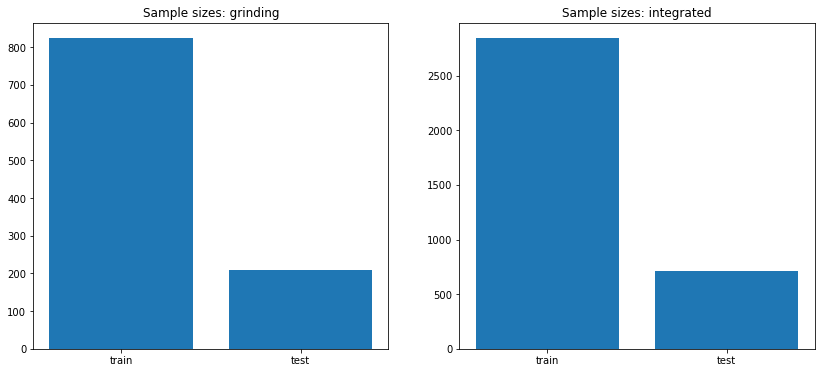

In [4]:
import matplotlib.pyplot as plt

# plot subset sample sizes for wet and dry classes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

classes = [ 'grinding', 'integrated' ]; 
for idx, c in enumerate( classes ):
    
    # get file list length - sample size
    count = [None] * 2
    for n, s in enumerate( [ 'train', 'test' ] ):
        path = os.path.join( os.path.join( os.getcwd(), 'data/chips/') , s )
        count[ n ] = len( os.listdir( os.path.join( path, c ) ) )
                
    # draw counts as subplot
    axes[idx].set_title( 'Sample sizes: {}'.format ( c ) )
    axes[idx].bar( [ 'train', 'test' ], count )


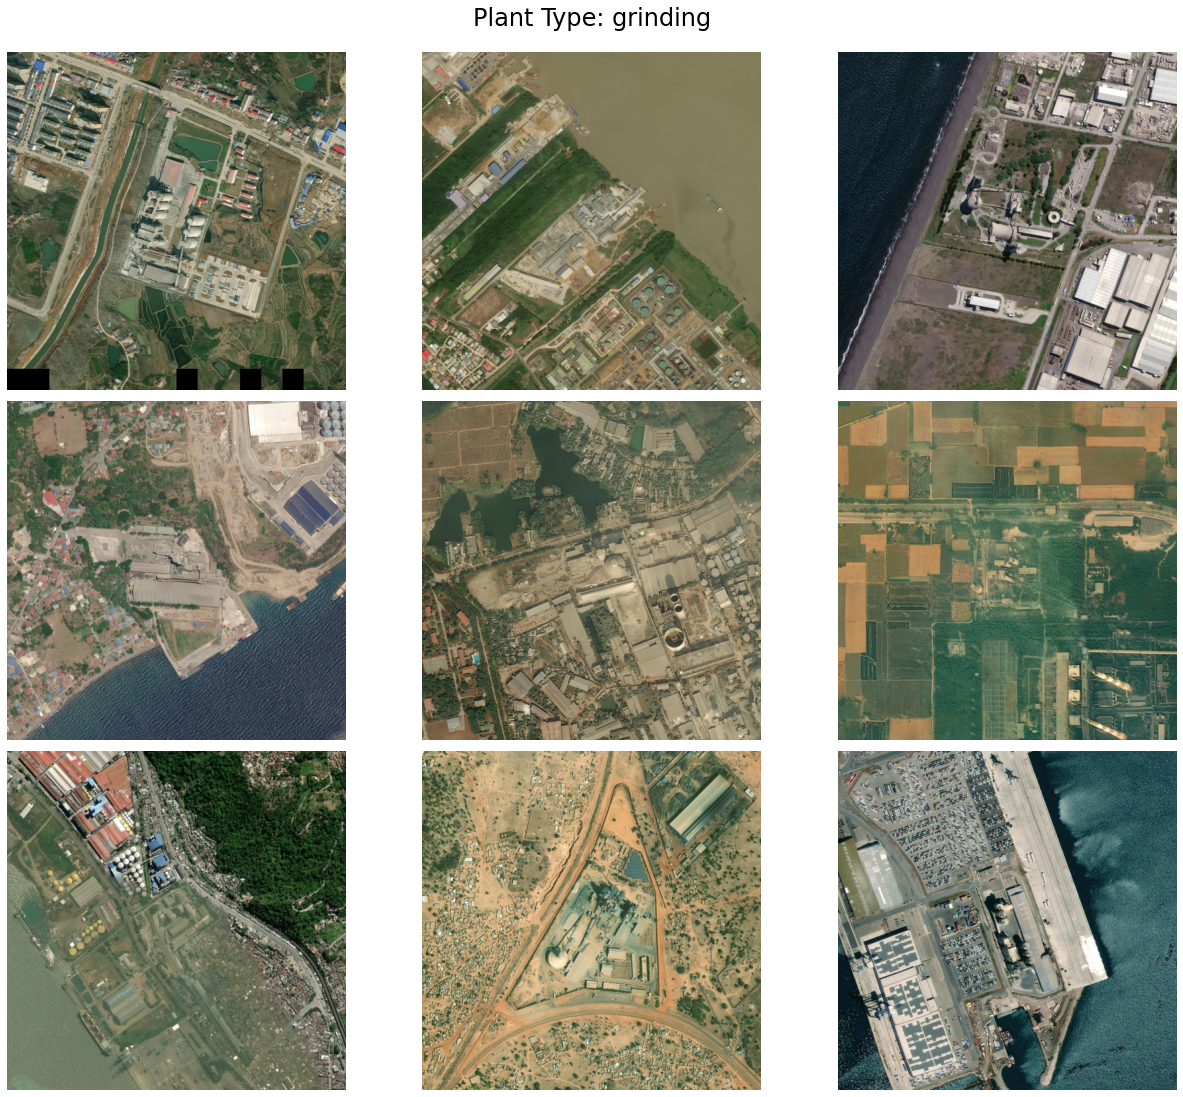

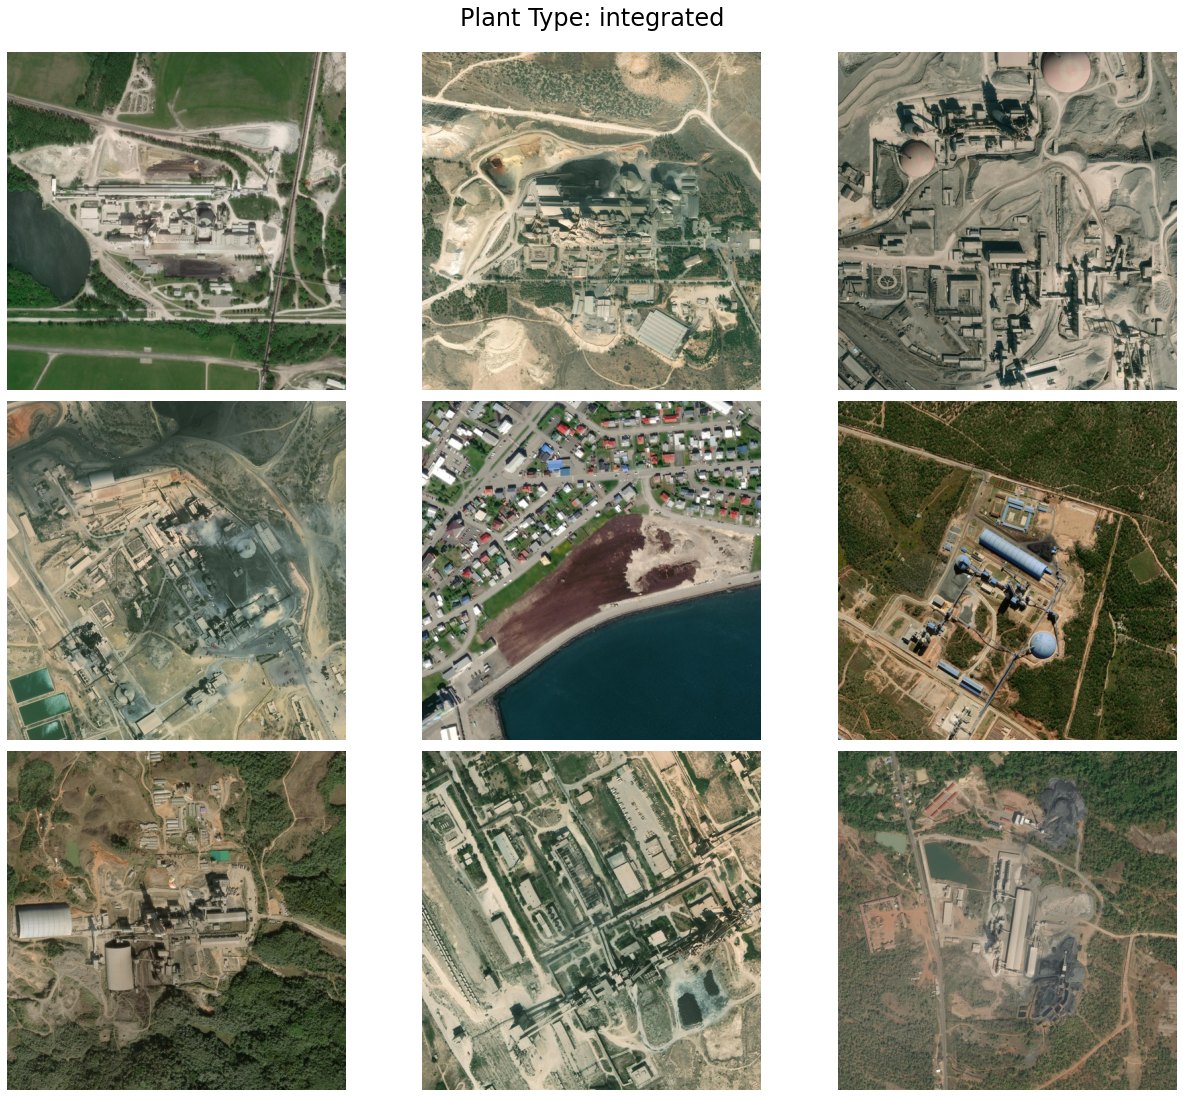

In [5]:
import random
from matplotlib.image import imread

# plot examples of wet and dry image chips 
classes = [ 'grinding', 'integrated' ]
for c in classes:
    
    fig = plt.figure( figsize=(18, 16) )    
    fig.suptitle('Plant Type: {}'.format( c ), fontsize=24)
    
    # randomly select entries from file list
    files = os.listdir( os.path.join( 'data/chips/test', c ) )
    random.shuffle( files )
    for i in range(9):

        # define subplot
        plt.subplot( 330 + 1 + i )
        plt.axis('off')

        # load and show image
        image = imread( os.path.join( os.path.join( 'data/chips/test', c ), files[ i ] ) )
        plt.imshow(image)

    # tight layout with adjustment
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## Model Architecture and Training

A pretrained VGG16 CNN model was selected as backbone for this analysis - output from CNN model was flattened and attached to two fully connected layers comprising 256 and 128 units respectively and assigned tanh activation functions. The model was trained using an Adam optimiser - learning rate = 1e-6 - combined with binary cross-entropy loss function weighted for imbalance in class sample sizes.

Diagnostics captured during training indicated a steady reduction in training loss and increase in precision and recall (> 0.95) over 2000 epochs - small adjustments were applied to Adam learning rate to refine model fit.

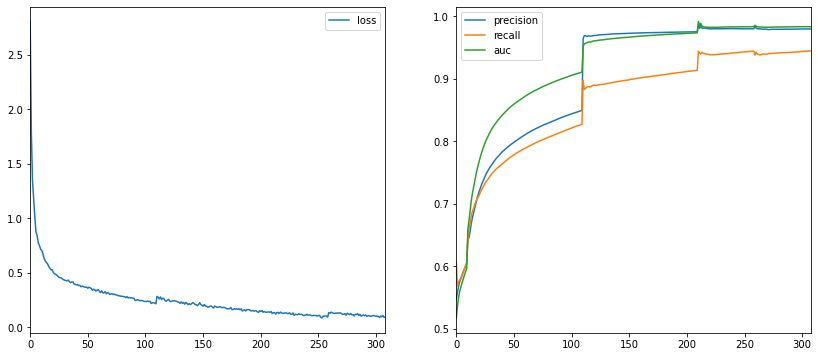

In [6]:
import pandas as pd

# plot diagnostics of model downloaded from GCS
df=pd.read_csv( os.path.join( os.getcwd(), 'models/vgg16-256-128/log.csv') )
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
df.plot.line( ax=axes[0], y=['loss'])
df.plot.line( ax=axes[1], y=['precision','recall','auc'])


## Results

Quality of binary classification model was assessed by computing confusion matrices against train and test subsets. As indicated in plots below, custom-built VGG16 CNN model converged to a fit delivering >95% accuracy on the training dataset. Test results indicated a degree of generalisation occurred where the model correctly identified plant type category of >75% test images. It is likely that grinding and integrated factories are relatively easy to discriminate based on footprint and presence of clearly visible on-site facilities such as rotary kilns.

These results provide a benchmark for further improvement - there are a number of potential avenues to explore for enhancing generalisation including assessment of hybrid models - architectures combining CNNs trained with imagery captured at different spatial resolutions - also MLP networks trained with socioeconomic / environment indicators specific to each site - for example, GDP, average monthly temperature, etc.


In [7]:
import tensorflow as tf

# initiate tensorflow session - allow access to all onboard CPU / GPU resources
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

In [8]:
from utility.dl.cnn import loadFromFile

# load pre-trained model from file - downloaded from GCS
model, model_type = loadFromFile( 'models/vgg16-256-128' )


Using TensorFlow backend.



Loaded model from disk: models/vgg16-256-128


In [9]:
import importlib
from keras.preprocessing.image import ImageDataGenerator

# select preprocess_input wrapper
module = importlib.import_module( 'keras.applications.{}'.format( model_type ) )
preprocess_input = module.preprocess_input
        
# create test generator
datagen = ImageDataGenerator( preprocessing_function=preprocess_input )


In [10]:
def getPrediction( path, model, datagen ):
    
    # get test iterator - binary classification
    it = datagen.flow_from_directory( path,
                                    class_mode=None, 
                                    color_mode='rgb',
                                    shuffle=False,
                                    batch_size=1, 
                                    target_size=(256,256) )
    
    # run prediction and threshold probabilities
    probabilities = model.predict_generator( it )
    return it, probabilities > 0.5


In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

def getConfusionMatrix( it, y_pred ):
    
    # compute normalised confusion matrix 
    cm = confusion_matrix( it.classes, y_pred )
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    classes = list( it.class_indices.keys() )
    return pd.DataFrame( cm, index=classes, columns=classes )


In [12]:
import seaborn as sn

def plotConfusionMatrix( df ):
    
    # plot dataframe as annotated heatmap
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('Normalised Confusion Matrix (Plant Type)')

    sn.set(font_scale=1.1) # for label size
    sn.heatmap(df, annot=True, annot_kws={"size": 16}, fmt='.2f' ) # font size

    plt.show()
    return


In [13]:
def getWronguns( it, y_pred ):
    
    # get pathnames of incorrectly classified images
    wronguns = { 'grinding': [], 'integrated' : [] }
    for idx, label in enumerate( it.class_indices.keys() ):
        items = np.argwhere( (it.classes==idx) & (y_pred.flatten()==1-idx) ).flatten()
        wronguns[ label ] = [ it.filepaths[i] for i in items ]

    return wronguns


In [14]:
def plotWronguns( wronguns ):
    
    # classes
    classes = [ 'grinding', 'integrated' ]
    for c in classes:
        
        num_images = min( 15, len( wronguns[ c ] ) )
        if num_images > 0:

            # get rows and columns
            columns = 5; rows = num_images / columns + 1    

            fig = plt.figure( figsize=(18, ( rows * 3 ) ) )
            fig.suptitle('Misclassfied Images: {}'.format( c ), fontsize=24)

            # display thumbnails of misclassified images
            for idx, pathname in enumerate( wronguns[ c ] ):

                image = imread( pathname )
                ax = plt.subplot( rows, columns, idx + 1 )
                ax.set_title( os.path.basename( pathname ) )

                plt.axis('off')            
                plt.imshow(image)
                
                if idx == num_images:
                    break

            # tight layout with adjustment
            fig.tight_layout(rect=[0, 0.05, 1, 0.95])    
            plt.show()
        
    return


Found 3666 images belonging to 2 classes.



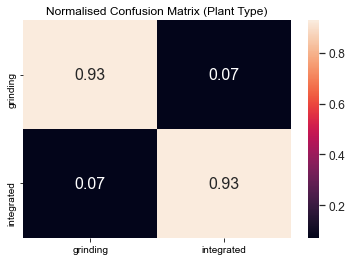

In [15]:
# get prediction
it, y_pred = getPrediction( os.path.join( os.getcwd(), 'data/chips/train' ), model, datagen )

# compute and plot confusion matrix
cm = getConfusionMatrix( it, y_pred )
plotConfusionMatrix( cm )

In [16]:
# identify and plot misclassified images
wronguns = getWronguns( it, y_pred )
# plotWronguns( wronguns )

Found 922 images belonging to 2 classes.


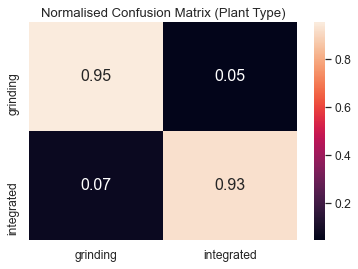

In [17]:
# get prediction
it, y_pred = getPrediction( os.path.join( os.getcwd(), 'data/chips/test' ), model, datagen )

# compute and plot confusion matrix
cm = getConfusionMatrix( it, y_pred )
plotConfusionMatrix( cm )

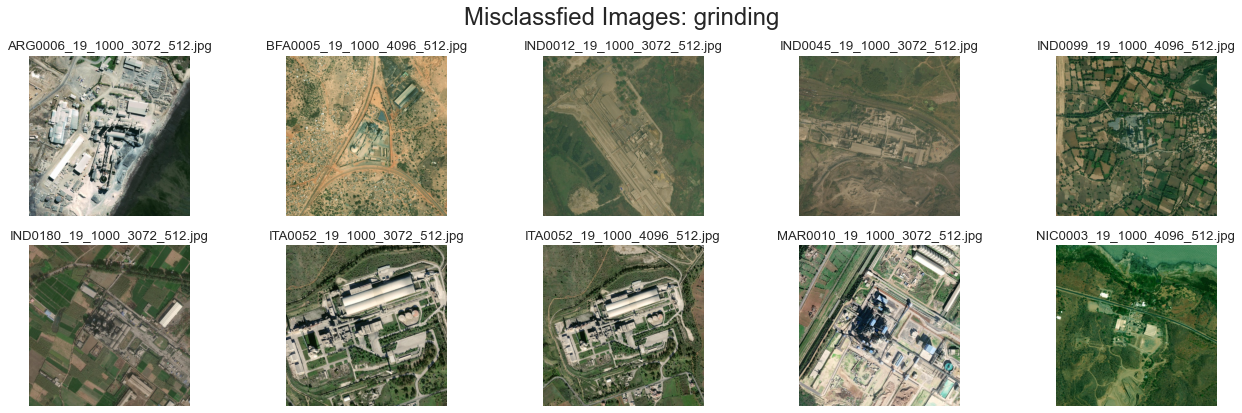

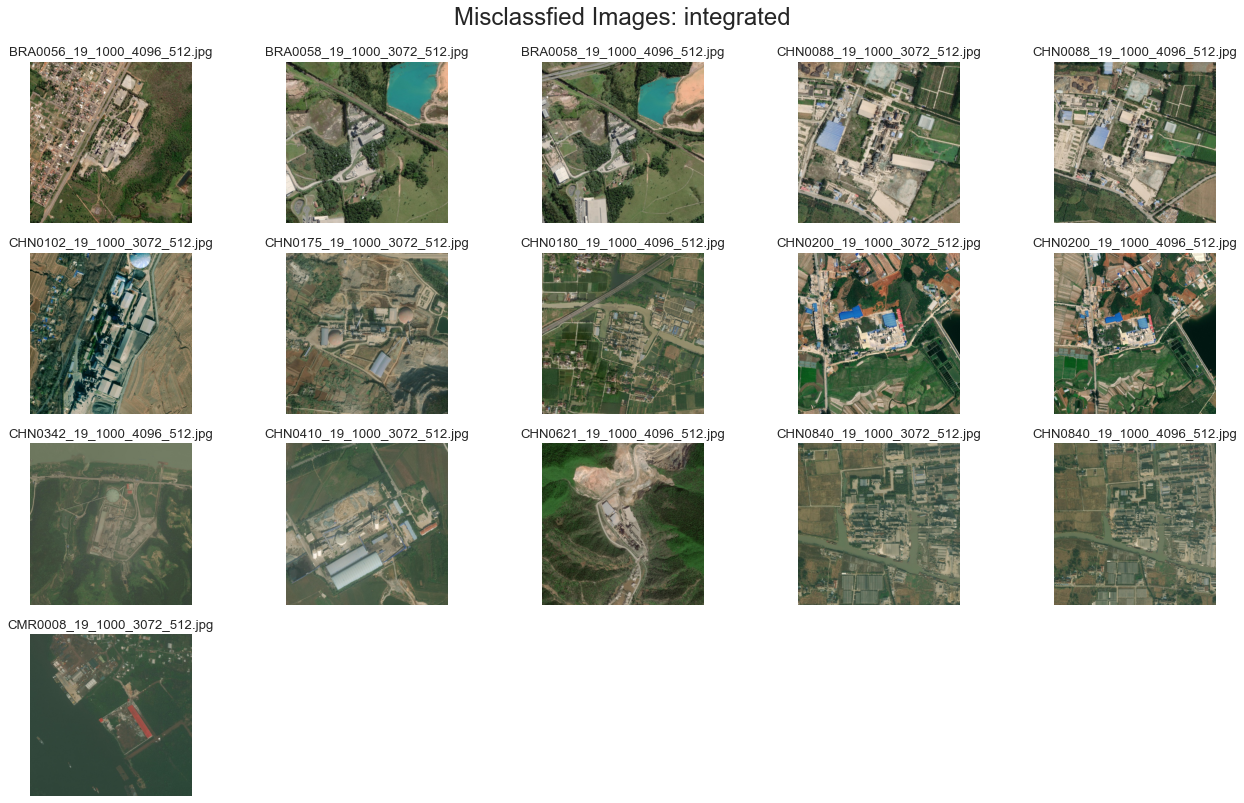

In [18]:
# identify and plot misclassified images
wronguns = getWronguns( it, y_pred )
plotWronguns( wronguns )